# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1 Data Loading and Preparation**

#### **Import Necessary Libraries**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

import tempfile

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
!pip install keras-tuner

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [ ]:
# Set the seed for the random module
import random
random.seed(42)

# Set the seed for numpy
np.random.seed(42)

# setting random state for tensorflow
tf.random.set_seed(42)

### **1.1 Data Aggregation**

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

In [ ]:
data_amazon=pd.read_csv('/content/drive/MyDrive/Stock_prediction/RNN_Stocks_Data/AMZN_stocks_data.csv')
data_amazon.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [ ]:
data_GOOGL=pd.read_csv('/content/drive/MyDrive/Stock_prediction/RNN_Stocks_Data/GOOGL_stocks_data.csv')
data_GOOGL.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [ ]:
data_IBM=pd.read_csv('/content/drive/MyDrive/Stock_prediction/RNN_Stocks_Data/IBM_stocks_data.csv')
data_IBM.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
data_MSFT=pd.read_csv('/content/drive/MyDrive/Stock_prediction/RNN_Stocks_Data/MSFT_stocks_data.csv')
data_MSFT.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them
import os
def load_data(folder_path, filenames):
    data_frames = []
    for filename in filenames:
        file_path = os.path.join(folder_path, filename)
        stock_name = filename.split('_')[0]

        df = pd.read_csv(file_path, parse_dates=['Date'])

        if 'Name' in df.columns:
            df = df.drop(columns=['Name'])

        df = df.rename(columns={
            'Open': f'Open_{stock_name}',
            'High': f'High_{stock_name}',
            'Low': f'Low_{stock_name}',
            'Close': f'Close_{stock_name}',
            'Volume': f'Volume_{stock_name}'
        })

        data_frames.append(df)

    main_df = data_frames[0]
    for df in data_frames[1:]:
        main_df = pd.merge(main_df, df, on='Date')

    # Sort by date
    main_df = main_df.sort_values('Date').reset_index(drop=True)

    return main_df




In [ ]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
filenames = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
folder_path = '/content/drive/MyDrive/Stock_prediction/RNN_Stocks_Data'
main_df = load_data(folder_path,filenames)

In [ ]:
# View specifics of the data
# Preview structure and contents of aggregated dataframe (main_df)
main_df.head()

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,211.47,218.05,209.32,217.83,13137450,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,222.17,224.70,220.09,222.84,15292353,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,223.22,226.00,220.97,225.85,10815661,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,228.66,235.49,226.85,233.06,17759521,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,233.44,236.94,230.70,233.68,12795837,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836


In [ ]:
main_df.tail()

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,1070.00,1071.72,1067.64,1068.86,889446,151.82,153.00,151.50,152.50,2990583,85.40,85.63,84.92,85.51,14145841
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,1068.64,1068.86,1058.64,1065.85,918767,152.51,153.86,152.50,152.83,2479017,85.31,85.53,85.03,85.40,9891237
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,1066.60,1068.27,1058.38,1060.20,1116203,152.95,153.18,152.61,153.13,2149257,85.65,85.98,85.22,85.71,14678025
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,1062.25,1064.84,1053.38,1055.95,994249,153.20,154.12,153.20,154.04,2687624,85.90,85.93,85.55,85.72,10594344
3018,2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,1055.49,1058.05,1052.70,1053.40,1180340,154.17,154.72,153.42,153.42,3327087,85.63,86.05,85.50,85.54,18717406


In [ ]:
# Check the number of rows and columns in the main DataFrame
main_df.shape # 3019 rows and 12 columns

(3019, 21)

In [ ]:
# Display summary information
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3019 non-null   datetime64[ns]
 1   Open_AMZN     3019 non-null   float64       
 2   High_AMZN     3019 non-null   float64       
 3   Low_AMZN      3019 non-null   float64       
 4   Close_AMZN    3019 non-null   float64       
 5   Volume_AMZN   3019 non-null   int64         
 6   Open_GOOGL    3019 non-null   float64       
 7   High_GOOGL    3019 non-null   float64       
 8   Low_GOOGL     3019 non-null   float64       
 9   Close_GOOGL   3019 non-null   float64       
 10  Volume_GOOGL  3019 non-null   int64         
 11  Open_IBM      3018 non-null   float64       
 12  High_IBM      3019 non-null   float64       
 13  Low_IBM       3018 non-null   float64       
 14  Close_IBM     3019 non-null   float64       
 15  Volume_IBM    3019 non-null   int64   

In [ ]:
# Generate descriptive statistics for numerical columns of main DataFrame
main_df.describe() # Amazon’s closing stock price shows strong long-term growth with high volatility, ranging from $26.07 to $1195.83 and a mean of ~$299.

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
count,3019,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3018.000000,3019.000000,3018.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,2012-01-01 20:00:33.388539392,299.335310,302.371163,296.037695,299.376231,5.931712e+06,428.200802,431.835618,424.130275,428.044001,3.551504e+06,145.521034,146.687493,144.477203,145.623031,5.773563e+06,36.496817,36.827903,36.173190,36.513412,5.161762e+07
min,2006-01-03 00:00:00,26.090000,26.300000,25.760000,26.070000,9.864350e+05,131.390000,134.820000,123.770000,128.850000,5.211410e+05,72.740000,73.940000,69.500000,71.740000,2.542560e+05,15.200000,15.620000,14.870000,15.150000,7.425603e+06
25%,2009-01-01 00:00:00,81.175000,82.580000,79.725000,81.090000,3.137037e+06,247.775000,250.190000,244.035000,247.605000,1.760854e+06,116.402500,117.750000,115.480000,116.520000,3.622178e+06,26.785000,27.045000,26.535000,26.835000,3.136557e+07
50%,2011-12-30 00:00:00,205.330000,208.000000,202.100000,205.440000,4.724100e+06,310.480000,312.810000,307.790000,310.080000,2.517630e+06,149.650000,150.410000,148.480000,149.330000,4.926500e+06,29.990000,30.230000,29.780000,30.000000,4.617529e+07
75%,2015-01-01 00:00:00,375.570000,379.155000,373.000000,375.140000,7.135246e+06,572.140000,575.975000,565.900000,570.770000,4.242182e+06,178.452500,179.775000,177.340000,178.690000,6.966642e+06,44.545000,44.980000,44.090000,44.400000,6.322291e+07
max,2017-12-29 00:00:00,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07,215.380000,215.900000,214.300000,215.800000,3.077428e+07,87.120000,87.500000,86.230000,86.850000,5.910786e+08
std,NaN,280.120547,281.826442,277.927134,279.980161,5.122034e+06,236.320026,237.514087,234.923747,236.343238,3.038599e+06,37.559958,37.618348,37.482585,37.534272,3.193327e+06,14.683337,14.742483,14.620057,14.694656,3.114958e+07


#### **1.1.2**
Identify and handle any missing values.

In [ ]:
# Handle Missing Values

main_df.isnull().sum()


,0
Date,0
Open_AMZN,0
High_AMZN,0
Low_AMZN,0
Close_AMZN,0
Volume_AMZN,0
Open_GOOGL,0
High_GOOGL,0
Low_GOOGL,0
Close_GOOGL,0


In [ ]:
# check for row with missing values
main_df[main_df.isnull().any(axis=1)]

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
2912,2017-07-31,1019.05,1019.05,987.02,987.78,7352063,960.0,961.19,941.72,945.5,2293389,NaN,144.93,NaN,144.67,4355718,73.3,73.44,72.41,72.7,23600054


In [ ]:
# dropping row with missing values

main_df.dropna(inplace=True)

In [ ]:
main_df.isnull().sum()

,0
Date,0
Open_AMZN,0
High_AMZN,0
Low_AMZN,0
Close_AMZN,0
Volume_AMZN,0
Open_GOOGL,0
High_GOOGL,0
Low_GOOGL,0
Close_GOOGL,0


### **1.2 Analysis and Visualisation**

#### **1.2.1**
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

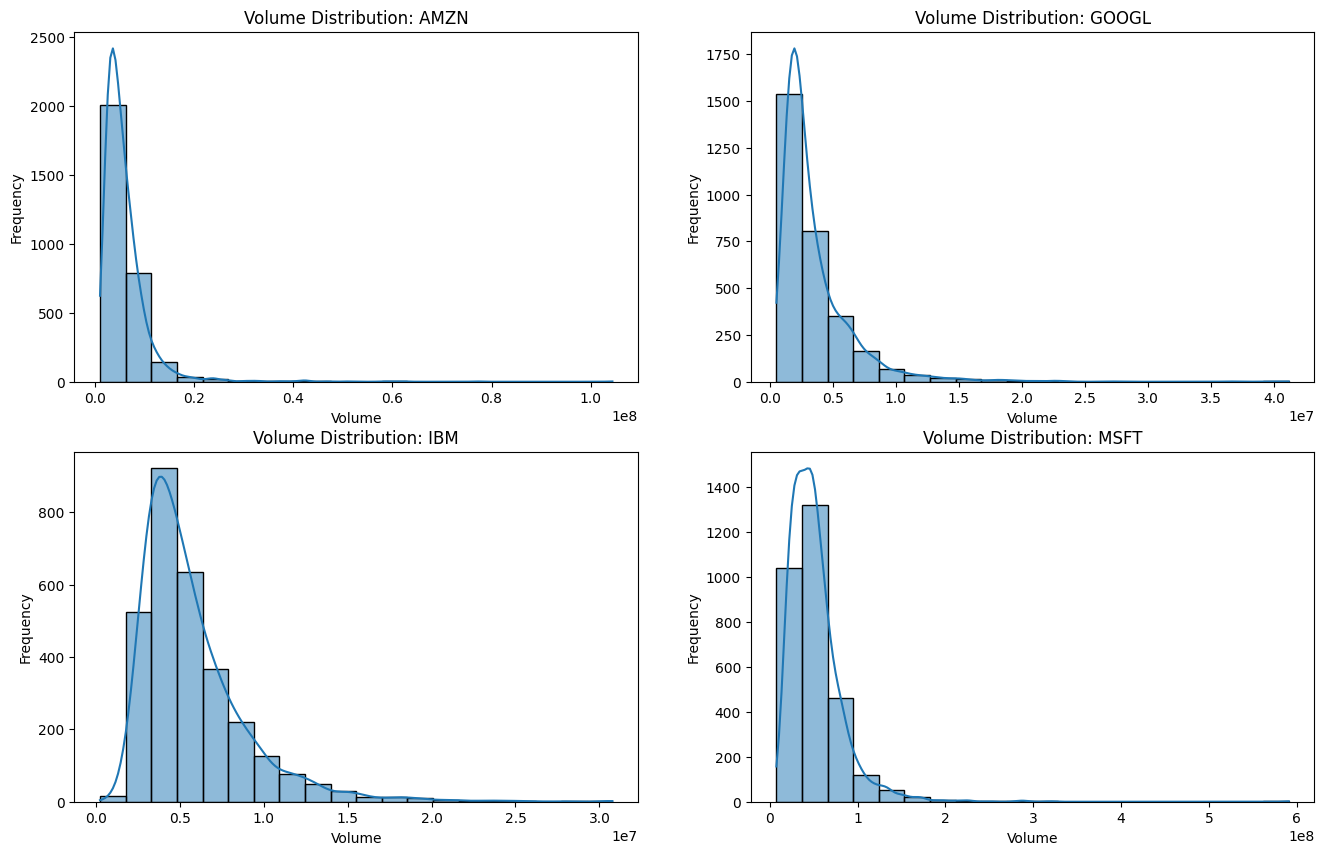

In [ ]:
# Frequency distribution of volumes

stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

plt.figure(figsize=(16, 10))
for i, stock in enumerate(stock_names):
    plt.subplot(2, 2, i+1)
    sns.histplot(main_df[f'Volume_{stock}'], kde=True, bins=20)
    plt.title(f'Volume Distribution: {stock}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.show()



All four distributions are right-skewed, indicating that most trading days had relatively low volume, with a few days of extremely high volume.


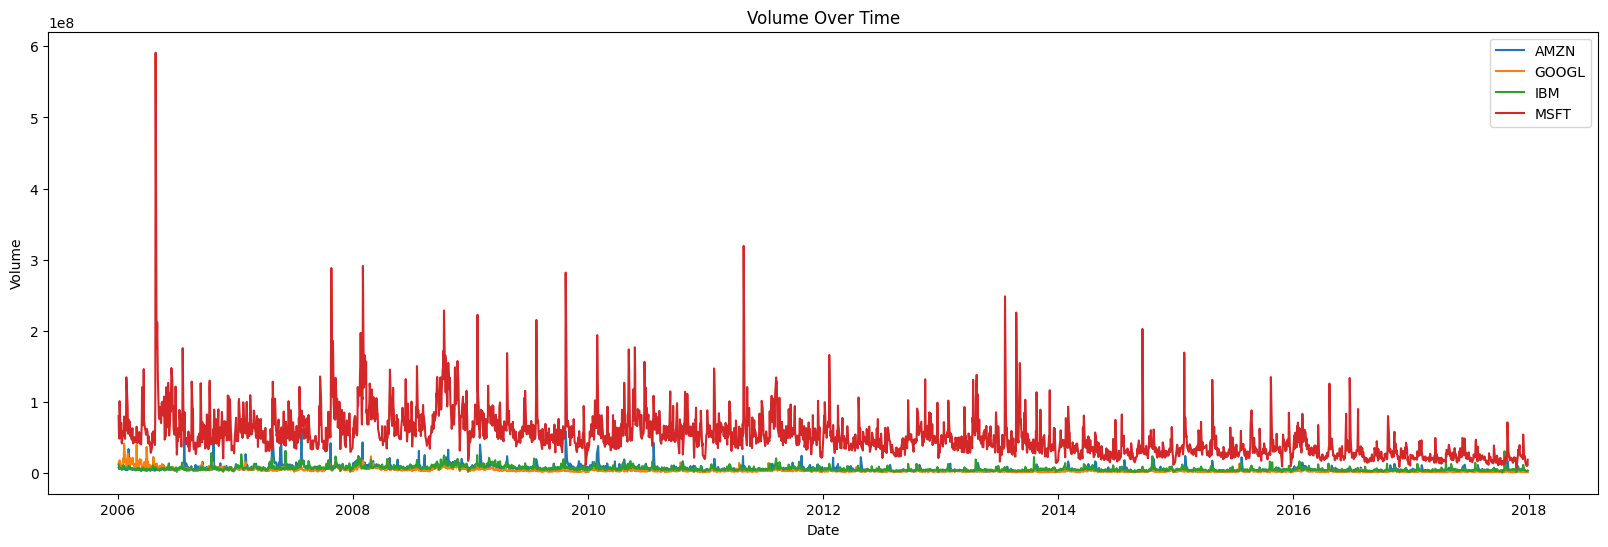

In [ ]:
# Stock volume variation over time

stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
plt.figure(figsize=(20, 6))
for stock in stock_names:
    plt.plot(main_df['Date'], main_df[f'Volume_{stock}'], label=f'{stock}')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

Time series plot of Volume Over Time from 2006 to 2018 for AMZN, GOOGL, IBM, and MSFT
MSFT consistently had the highest and most volatile trading volume from 2006 to 2018, with occasional sharp spikes far exceeding other stocks.


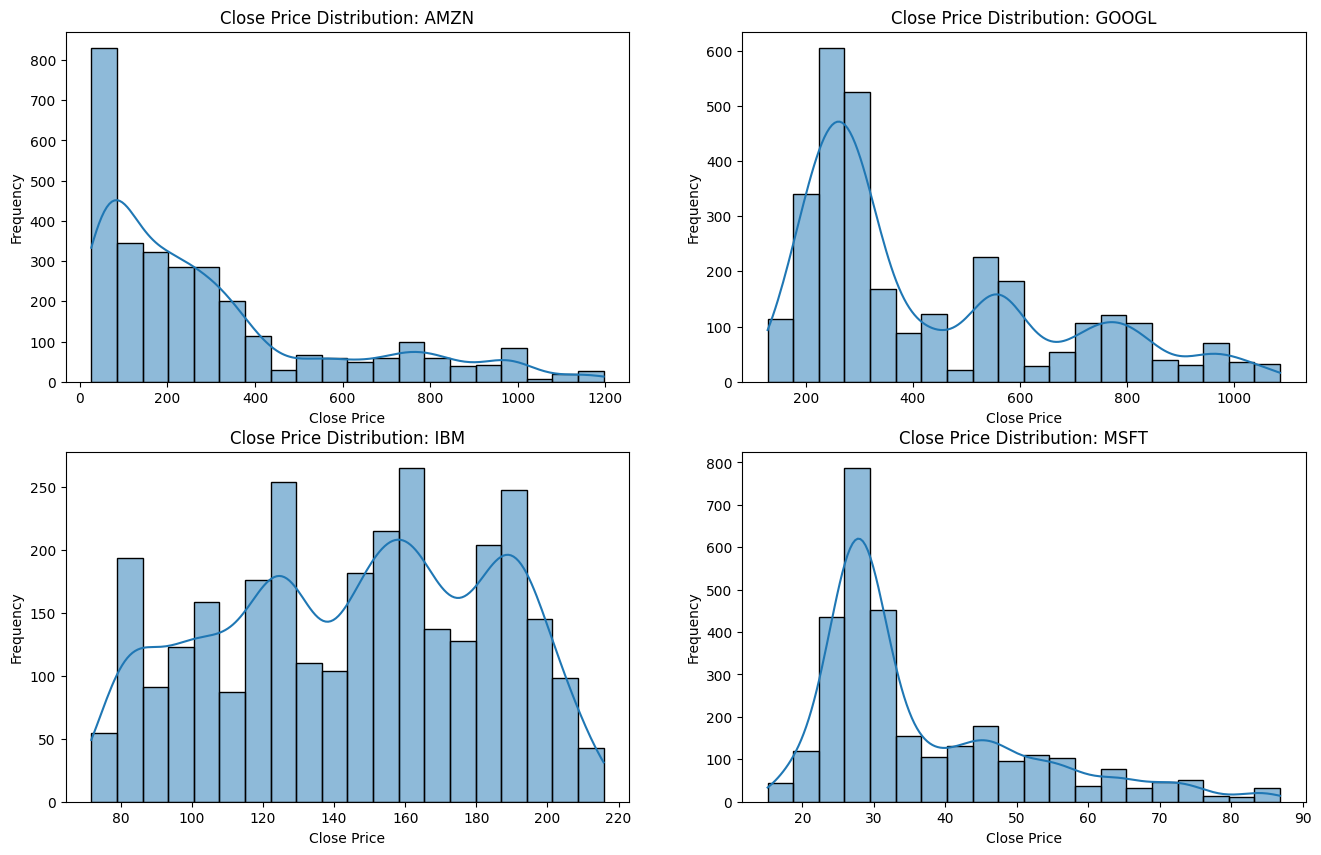

In [ ]:
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

plt.figure(figsize=(16, 10))
for i, stock in enumerate(stock_names):
    plt.subplot(2, 2, i+1)
    sns.histplot(main_df[f'Close_{stock}'], kde=True, bins=20)
    plt.title(f'Close Price Distribution: {stock}')
    plt.xlabel('Close Price')
    plt.ylabel('Frequency')


Hist plot of AMZN and GOOGL have positively skewed price distributions, while IBM displays a more uniform distribution, and MSFT is tightly clustered at lower prices.

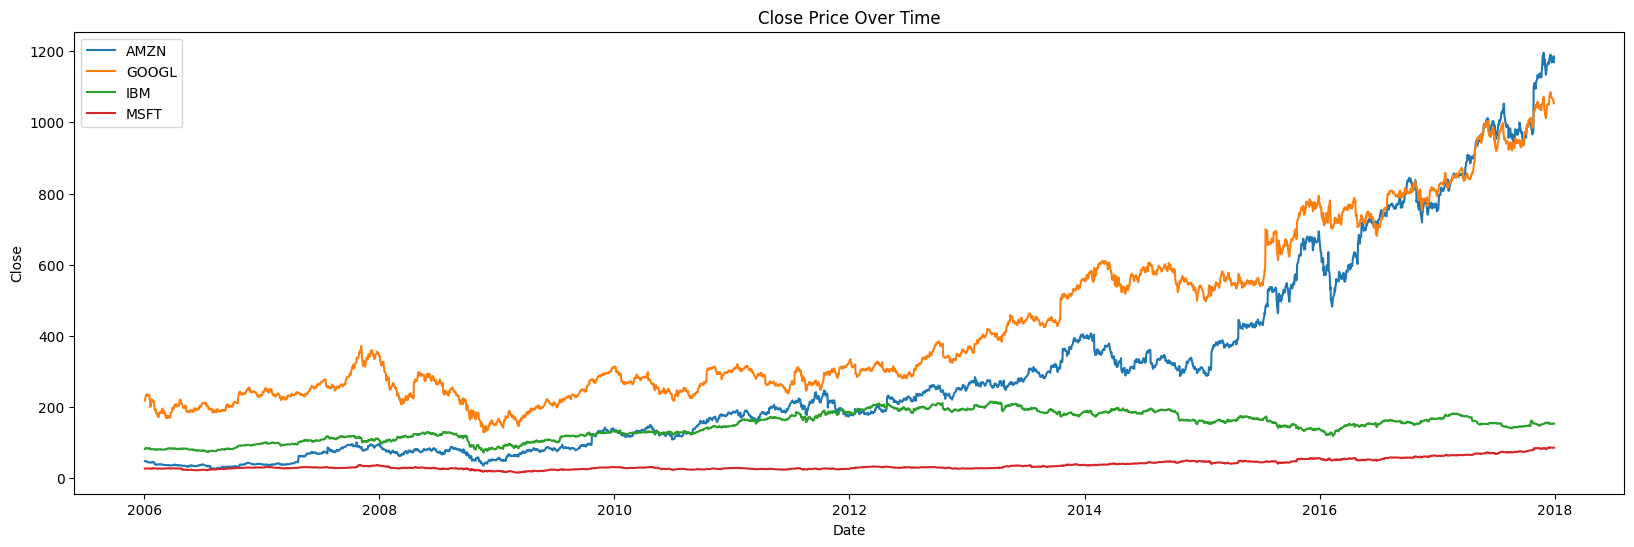

In [ ]:
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
plt.figure(figsize=(20, 6))
for stock in stock_names:
    plt.plot(main_df['Date'], main_df[f'Close_{stock}'], label=f'{stock}')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

close price of amazon overtime has crossed google while IBM and MSFT didnt change much over the period.
This could indicate stronger growth for Amazon compared to Google during that specific timeframe.
While IBM and MSFT also experienced increases in their closing prices, their growth was comparatively less

#### **1.2.2**
Analyse correlations between features.

In [ ]:
# Analyse correlations

correlation_matrix=main_df.iloc[:,1:].corr()
correlation_matrix

,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,Volume_GOOGL,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
Open_AMZN,1.000000,0.999931,0.999897,0.999834,-0.328318,0.972644,0.972504,0.972994,0.972735,-0.440793,0.396641,0.393732,0.397839,0.395173,-0.372165,0.953434,0.953345,0.953419,0.953446,-0.488958
High_AMZN,0.999931,1.000000,0.999889,0.999924,-0.326409,0.972767,0.972710,0.973154,0.972955,-0.440776,0.397116,0.394265,0.398315,0.395709,-0.371636,0.953299,0.953281,0.953304,0.953392,-0.488203
Low_AMZN,0.999897,0.999889,1.000000,0.999930,-0.330015,0.972317,0.972215,0.972828,0.972567,-0.441497,0.396266,0.393356,0.397539,0.394865,-0.373330,0.953503,0.953436,0.953625,0.953644,-0.490040
Close_AMZN,0.999834,0.999924,0.999930,1.000000,-0.328009,0.972482,0.972442,0.972984,0.972817,-0.441292,0.396644,0.393798,0.397919,0.395349,-0.372818,0.953331,0.953326,0.953443,0.953563,-0.489236
Volume_AMZN,-0.328318,-0.326409,-0.330015,-0.328009,1.000000,-0.335282,-0.334037,-0.337847,-0.336239,0.327214,-0.389324,-0.386539,-0.392234,-0.389026,0.390736,-0.279138,-0.277289,-0.282671,-0.280460,0.384698
Open_GOOGL,0.972644,0.972767,0.972317,0.972482,-0.335282,1.000000,0.999894,0.999841,0.999743,-0.443231,0.411837,0.408774,0.413145,0.410178,-0.384548,0.968742,0.968778,0.968578,0.968750,-0.510437
High_GOOGL,0.972504,0.972710,0.972215,0.972442,-0.334037,0.999894,1.000000,0.999827,0.999866,-0.440786,0.410579,0.407616,0.411906,0.409028,-0.382638,0.968652,0.968803,0.968520,0.968788,-0.509071
Low_GOOGL,0.972994,0.973154,0.972828,0.972984,-0.337847,0.999841,0.999827,1.000000,0.999896,-0.447852,0.413376,0.410321,0.414849,0.411868,-0.387848,0.968731,0.968789,0.968764,0.968928,-0.513416
Close_GOOGL,0.972735,0.972955,0.972567,0.972817,-0.336239,0.999743,0.999866,0.999896,1.000000,-0.444655,0.411987,0.409043,0.413462,0.410647,-0.385487,0.968578,0.968737,0.968606,0.968930,-0.511782
Volume_GOOGL,-0.440793,-0.440776,-0.441497,-0.441292,0.327214,-0.443231,-0.440786,-0.447852,-0.444655,1.000000,-0.546490,-0.544280,-0.549512,-0.546949,0.445371,-0.363245,-0.361593,-0.365737,-0.364325,0.441054


<Axes: >

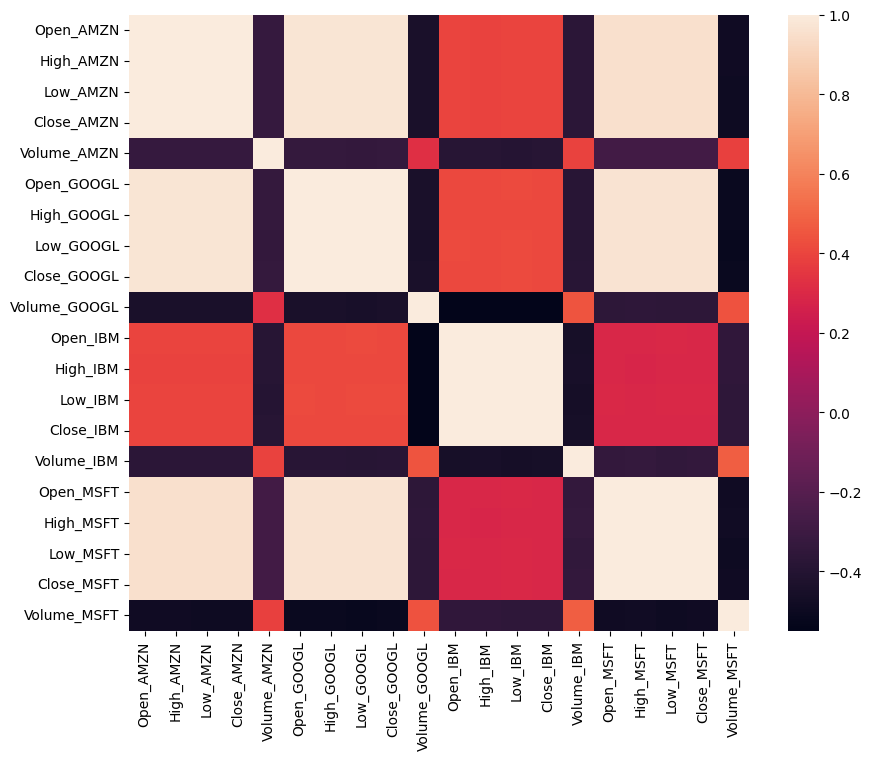

In [ ]:
# Heatmap to visualise correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix)

Amazon's closing price is moderately correlated with Google's

Amazon's close price movements are largely independent of IBM and Microsoft.




### **1.3 Data Processing**

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

In [ ]:
# Extract Day, month and Year from Date column and dropping Date column
main_df['Date'] = pd.to_datetime(main_df['Date'])

main_df['Day'] = main_df['Date'].dt.day
main_df['Month'] = main_df['Date'].dt.month
main_df['Year'] = main_df['Date'].dt.year

main_df = main_df.drop('Date',axis=1)

#### **1.3.1**
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [ ]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_window(IP, OP, window_size=10, window_stride=5):

    n = len(IP)

    X = []
    y = []

    for start in range(0, n-window_size, window_stride):
        X.append(IP[start : start + window_size])
        y.append(OP[start+window_size])
    X = np.array(X)
    y = np.array(y)

    return X, y

#### **1.3.2**
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [ ]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

X_sclr = MinMaxScaler()
y_sclr = MinMaxScaler()

def scale_windowed_data(X_train, X_test, y_train, y_test, window_size=10, window_stride=5):


    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    X_train = X_sclr.fit_transform(X_train)
    y_train = y_sclr.fit_transform(y_train)

    X_test = X_sclr.transform(X_test)
    y_test = y_sclr.transform(y_test)

    X_train, y_train = create_window(X_train, y_train, window_size=window_size, window_stride=window_stride)
    X_test, y_test = create_window(X_test, y_test, window_size=window_size, window_stride=window_stride)

    return X_train, X_test, y_train, y_test

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3**
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame


def train_test(df, target, window_size, window_stride=10, test_size=5):

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test = X[:int((1-test_size)*len(X))], X[int((1-test_size)*len(X)):]
    y_train, y_test = y[:int((1-test_size)*len(X))], y[int((1-test_size)*len(X)):]

    X_train, X_test, y_train, y_test = scale_windowed_data(X_train, X_test, y_train, y_test, window_size=window_size, window_stride=window_stride)

    return X_train, X_test, y_train, y_test


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4**
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

<Axes: xlabel='Year', ylabel='Close_AMZN'>

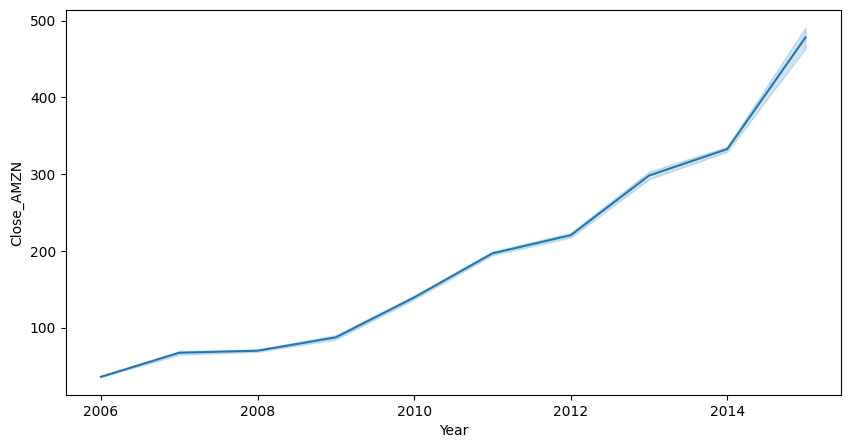

In [ ]:
# Checking for patterns in different sequence lengths
df1=main_df.copy()
df1=df1[(df1['Year'] >= 2006) & (df1['Year'] <= 2015)]

plt.figure(figsize=(10, 5))

sns.lineplot(data=df1, x='Year', y='Close_AMZN')

<Axes: xlabel='Year', ylabel='Close_AMZN'>

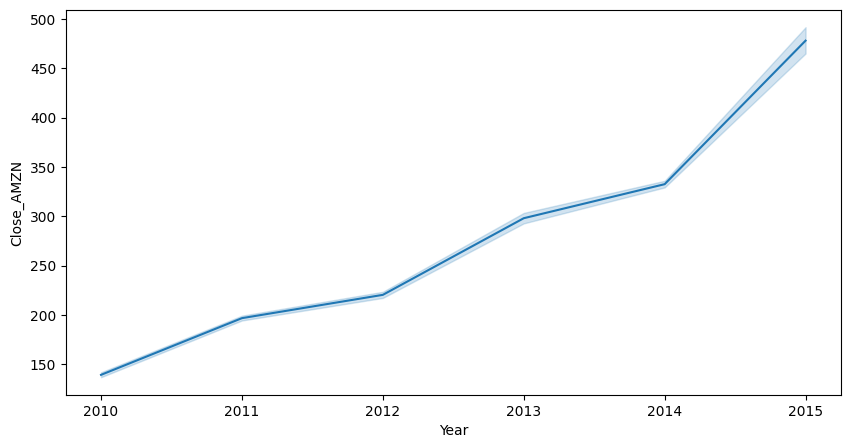

In [ ]:
df1=df1[(df1['Year'] >= 2010) & (df1['Year'] <= 2018)]
plt.figure(figsize=(10, 5))

sns.lineplot(data=df1, x='Year', y='Close_AMZN')

#### **1.3.5**
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride

target_col = 'Close_AMZN'
window_size = 10
window_stride = 5
test_size = 0.2

# Create datasets
X_train, X_test, y_train, y_test = train_test(main_df, target_col, window_size, window_stride, test_size)


In [ ]:
# Check the number of data points generated
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

481
119
481
119


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks

print(f'X train shape {X_train.shape}')
print(f'X test shape {X_test.shape}')
print(f'y train shape {y_train.shape}')
print(f'X train shape {y_test.shape}')


X train shape (481, 10, 22)
X test shape (119, 10, 22)
y train shape (481, 1)
X train shape (119, 1)


## **2 RNN Models**

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model**

#### **2.1.1**
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def Create_SimpleRNN(config=None):

    if config == None:
        config = {'layers': 2, 'units':[125, 150], 'activation':['linear', 'linear'], 'dropout':[0, 0]}

    n = config['layers']

    model=Sequential()
    model.add(Input(shape = X_train.shape[1:]))

    for i in range(n):
        rtn_seq = (i<n-1)
        model.add(SimpleRNN(units=config['units'][i], activation=config['activation'][i], dropout=config['dropout'][i], return_sequences=rtn_seq))

    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(model.summary())

    return model


In [ ]:
model = Create_SimpleRNN() # Create an instance of the RNN model using the Create_RNN function

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True) # Implement early stopping to prevent overfitting

# Train the Simple RNN model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10, 125)        │        18,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 150)            │        41,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,051 (234.57 KB)

 Trainable params: 60,051 (234.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 5.1113 - mae: 1.5185 - val_loss: 1.1443 - val_mae: 0.9506
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3768 - mae: 0.5207 - val_loss: 0.0577 - val_mae: 0.1890
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360 - mae: 0.1517 - val_loss: 0.0194 - val_mae: 0.1162
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - mae: 0.0898 - val_loss: 0.0679 - val_mae: 0.2251
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0620 - val_loss: 0.0526 - val_mae: 0.2026
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0541 - val_loss: 0.0351 - val_mae: 0.1642
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mae: 0.0501 - val_loss: 0.0288 - val_mae: 0.1484
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0470 - val_loss: 0.0177 - val_mae: 0.1152
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 

In [ ]:
# function uses the trained model to make predictions on the
# given input data (X) and provides options for visualization and
# returning the predicted values.


def Make_Predictions(model, X=X_test, plot=True, Val_Out=True):

    y_pred = model.predict(X)

    inv_y_pred = y_sclr.inverse_transform(y_pred)
    inv_y_test = y_sclr.inverse_transform(y_test)

    if plot == True:
        y_pred = model.predict(X)
        plt.figure(figsize=(10, 5))
        plt.plot(inv_y_test, label='True')
        plt.plot(inv_y_pred, label='Predicted')
        plt.legend()
        plt.title("Model Predictions vs True Values")
        plt.show()

    if Val_Out == True:
         return y_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


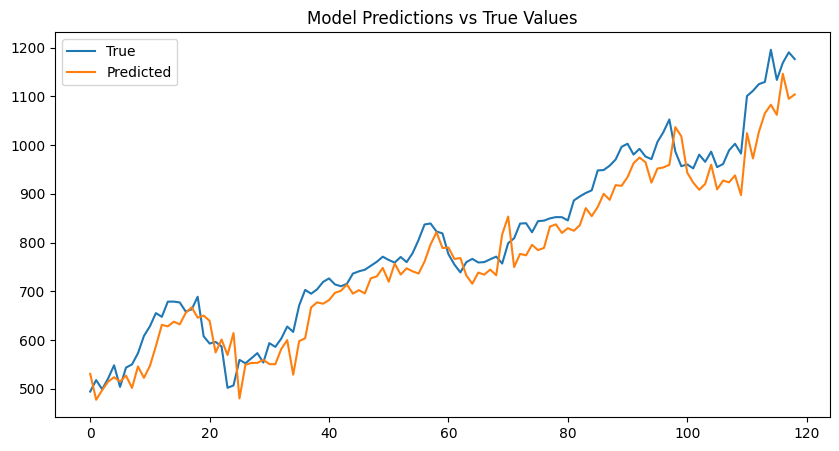

In [ ]:
Make_Predictions(model,Val_Out=False)

#### **2.1.2**
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN

configs = [
    {'layers':2, 'units':[125, 150], 'activation':['linear', 'linear'], 'dropout':[0, 0]},
    {'layers':2, 'units':[150, 150], 'activation':['linear', 'linear'], 'dropout':[0, 0.1]},
    {'layers':3, 'units':[75, 100, 125], 'activation':['linear', 'linear', 'linear'], 'dropout':[0.3, 0.2, 0.3]},
    {'layers':3, 'units':[100, 100, 100], 'activation':['linear', 'linear', 'linear'], 'dropout':[0.2, 0.1, 0.1]},
    {'layers':3, 'units':[150, 150, 200], 'activation':['linear', 'linear', 'linear'], 'dropout':[0.1, 0.2, 0.1]}
]

#### **2.1.3**
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

best_config = None
best_mae = float('inf')

# Set up ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_mae', save_best_only=True, mode='min')

for i in range(len(configs)):

    print(configs[i])
    model = Create_SimpleRNN(configs[i])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Loss: {loss}, MAE: {mae}")
    print(75*'+=')
    print()


    if mae < best_mae:
        best_config = configs[i]
        best_mae = mae
print()
print(f"Best config: {best_config}, MAE: {best_mae}")

# Load the best model with custom objects
best_model = load_model('best_model.h5', custom_objects={'mse': 'mean_squared_error', 'mae': 'mean_absolute_error'})


{'layers': 2, 'units': [125, 150], 'activation': ['linear', 'linear'], 'dropout': [0, 0]}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 10, 125)        │        18,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 150)            │        41,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,051 (234.57 KB)

 Trainable params: 60,051 (234.57 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 16.2187 - mae: 2.5182

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 15.9583 - mae: 2.5026 - val_loss: 5.8610 - val_mae: 2.3698
Epoch 2/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0523 - mae: 0.8575

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9651 - mae: 0.8102 - val_loss: 0.5031 - val_mae: 0.6804
Epoch 3/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1686 - mae: 0.3364 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1567 - mae: 0.3232 - val_loss: 0.1210 - val_mae: 0.3283
Epoch 4/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - mae: 0.1424 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0340 - mae: 0.1454 - val_loss: 0.1176 - val_mae: 0.3242
Epoch 5/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210 - mae: 0.1169  

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195 - mae: 0.1115 - val_loss: 0.0148 - val_mae: 0.1000
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0737 - val_loss: 0.0215 - val_mae: 0.1253
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0659 - val_loss: 0.0160 - val_mae: 0.1058
Epoch 8/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - mae: 0.0619 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - mae: 0.0609 - val_loss: 0.0124 - val_mae: 0.0914
Epoch 9/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - mae: 0.0560 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - mae: 0.0554 - val_loss: 0.0092 - val_mae: 0.0771
Epoch 10/10
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mae: 0.0531 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0526 - val_loss: 0.0085 - val_mae: 0.0736
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - mae: 0.0727
Loss: 0.008501967415213585, MAE: 0.07356894016265869
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

{'layers': 2, 'units': [150, 150], 'activation': ['linear', 'linear'], 'dropout': [0, 0.1]}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 10, 150)        │        25,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,251 (278.32 KB)

 Trainable params: 71,251 (278.32 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 17.0228 - mae: 2.8595 - val_loss: 0.2874 - val_mae: 0.4437
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4622 - mae: 0.5350 - val_loss: 1.1070 - val_mae: 0.9839
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0906 - mae: 0.2295 - val_loss: 0.2287 - val_mae: 0.4190
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0625 - mae: 0.1936 - val_loss: 0.2284 - val_mae: 0.4187
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0346 - mae: 0.1426 - val_loss: 0.2211 - val_mae: 0.4259
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285 - mae: 0.1353 - val_loss: 0.0551 - val_mae: 0.2005
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 - mae: 0.1186 - val_loss: 0.1210 - val_mae: 0.3141
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0265 - mae: 0.1291 - val_loss: 0.0968 - val_mae: 0.2805
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.02

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 10, 75)         │         7,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 10, 100)        │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 125)            │        28,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,326 (208.30 KB)

 Trainable params: 53,326 (208.30 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - loss: 83.5533 - mae: 6.5570 - val_loss: 8.7076 - val_mae: 2.9199
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.9636 - mae: 1.7810 - val_loss: 0.4186 - val_mae: 0.5731
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7461 - mae: 1.4745 - val_loss: 0.1156 - val_mae: 0.2757
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0619 - mae: 1.0951 - val_loss: 1.6346 - val_mae: 1.2375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3371 - mae: 0.8765 - val_loss: 0.3402 - val_mae: 0.5402
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0011 - mae: 0.7627 - val_loss: 0.0417 - val_mae: 0.1604
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2593 - mae: 0.8029 - val_loss: 0.3655 - val_mae: 0.5588
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8911 - mae: 0.7070 - val_loss: 0.6993 - val_mae: 0.7941
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)        │ (None, 10, 100)        │        12,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 10, 100)        │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,601 (205.47 KB)

 Trainable params: 52,601 (205.47 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - loss: 93.5806 - mae: 7.0498 - val_loss: 3.4361 - val_mae: 1.6896
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.8208 - mae: 2.0592 - val_loss: 2.8637 - val_mae: 1.6566
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9560 - mae: 1.0957 - val_loss: 1.6645 - val_mae: 1.2247
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5848 - mae: 0.5917 - val_loss: 0.7474 - val_mae: 0.7722
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5239 - mae: 0.5435 - val_loss: 1.1149 - val_mae: 0.9950
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5035 - mae: 0.5361 - val_loss: 1.1545 - val_mae: 1.0279
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5054 - mae: 0.5388 - val_loss: 0.2193 - val_mae: 0.4442
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4676 - mae: 0.5094 - val_loss: 0.0484 - val_mae: 0.1756
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)       │ (None, 10, 150)        │        25,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 10, 150)        │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 200)            │        70,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,501 (552.74 KB)

 Trainable params: 141,501 (552.74 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - loss: 192.6634 - mae: 8.9292 - val_loss: 19.2856 - val_mae: 4.3550
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.9582 - mae: 2.0978 - val_loss: 4.0293 - val_mae: 1.9251
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9946 - mae: 0.7363 - val_loss: 2.9227 - val_mae: 1.6033
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4337 - mae: 0.5220 - val_loss: 0.3728 - val_mae: 0.5613
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3766 - mae: 0.4833 - val_loss: 0.0795 - val_mae: 0.2420
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3216 - mae: 0.4526 - val_loss: 0.1531 - val_mae: 0.3477
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3571 - mae: 0.4481 - val_loss: 0.0688 - val_mae: 0.2276
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3020 - mae: 0.4113 - val_loss: 0.6156 - val_mae: 0.7530
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - l

Loss: 0.2726532816886902, MAE: 0.47291100025177
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=


Best config: {'layers': 2, 'units': [125, 150], 'activation': ['linear', 'linear'], 'dropout': [0, 0]}, MAE: 0.07356894016265869


**Best config: {'layers': 2, 'units': [125, 150], 'activation': ['linear', 'linear'], 'dropout': [0, 0]}, MAE: 0.073**


Plotting the actual vs predicted values

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


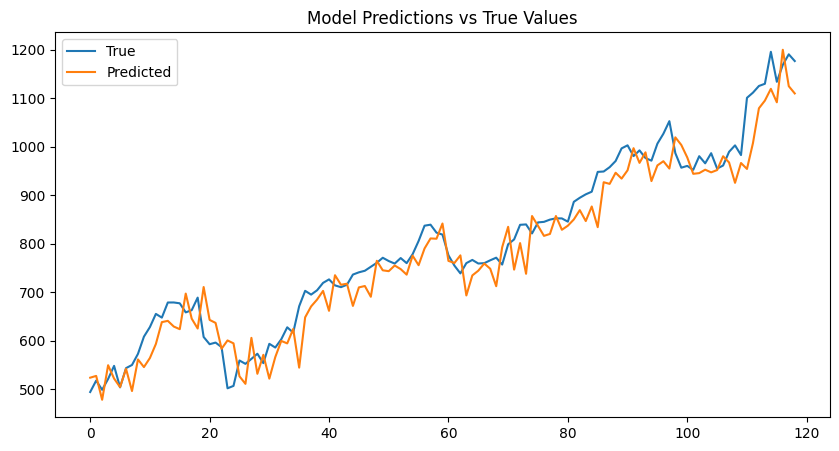

In [ ]:
# Predict on the test data and plot

Make_Predictions(best_model,Val_Out=False)


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set
# Get predictions from the model
y_pred = Make_Predictions(best_model, X=X_test, plot=False, Val_Out=True)

# Compute Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Squared Error: 0.00850196598847835
R-squared: 0.9305371111136913


**Simple RNN gives low MSE and a high R-squared**

In [ ]:
# Build and compile a SimpleRNN model with tunable hyperparameters.

def build_SimpleRNN(hp):

    n = hp.Int('layers', min_value=1, max_value=3)

    model = Sequential()
    model.add(Input(shape = X_train.shape[1:]))

    for i in range(n):
        rtn_seq = (i<n-1)
        model.add(SimpleRNN(units=hp.Int('units', min_value=75, max_value=150, step=25),
                        activation=hp.Choice('activation', values=['linear', 'linear']),
                        dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
                        return_sequences=rtn_seq))

    model.add(Dense(units=1))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    return model

In [ ]:
# Initializes a Hyperband tuner for efficient hyperparameter search.
hyperband_tunner = kt.Hyperband(
    build_SimpleRNN,
    objective='val_mae',
    max_epochs=10,
    factor=3,
    directory='tempfile.mkdtemp',
    project_name='hyperband_rnn',
    overwrite=True
)

In [ ]:
# Performing hyperparameter search and using summary to display results

hyperband_tunner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

hyperband_tunner.results_summary()


Trial 30 Complete [00h 00m 07s]
val_mae: 0.276481032371521

Best val_mae So Far: 0.07675925642251968
Total elapsed time: 00h 04m 57s
Results summary
Results in tempfile.mkdtemp/hyperband_rnn
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0017 summary
Hyperparameters:
layers: 2
units: 100
activation: linear
dropout: 0.0
learning_rate: 0.0003460139305208059
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.07675925642251968

Trial 0026 summary
Hyperparameters:
layers: 1
units: 75
activation: linear
dropout: 0.1
learning_rate: 0.0018808184545942707
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10356166213750839

Trial 0024 summary
Hyperparameters:
layers: 2
units: 75
activation: linear
dropout: 0.0
learning_rate: 0.001830211200709093
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.10410180687904358

Trial 0025 summary
Hyperp

In [ ]:
# printing the best hyperparameters

best_hyperparameters = hyperband_tunner.get_best_hyperparameters(num_trials=1)[0] # Access the first element of the list

best_hyperparameters.values # Now you can access the 'values' attribute

{'layers': 2,
 'units': 100,
 'activation': 'linear',
 'dropout': 0.0,
 'learning_rate': 0.0003460139305208059,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [ ]:
# Build the best model using the best hyperparameters
best_model = hyperband_tunner.hypermodel.build(best_hyperparameters)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 1.8289 - mae: 1.0371 - val_loss: 0.8034 - val_mae: 0.7843
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2740 - mae: 0.4035 - val_loss: 0.1199 - val_mae: 0.2941
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0687 - mae: 0.2062 - val_loss: 0.2658 - val_mae: 0.4626
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0406 - mae: 0.1515 - val_loss: 0.0627 - val_mae: 0.2079
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0275 - mae: 0.1248 - val_loss: 0.0585 - val_mae: 0.2035
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - mae: 0.1061 - val_loss: 0.0296 - val_mae: 0.1389
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - mae: 0.0965 - val_loss: 0.0326 - val_mae: 0.1480
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - mae: 0.0907 - val_loss: 0.0258 - val_mae: 0.1299
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


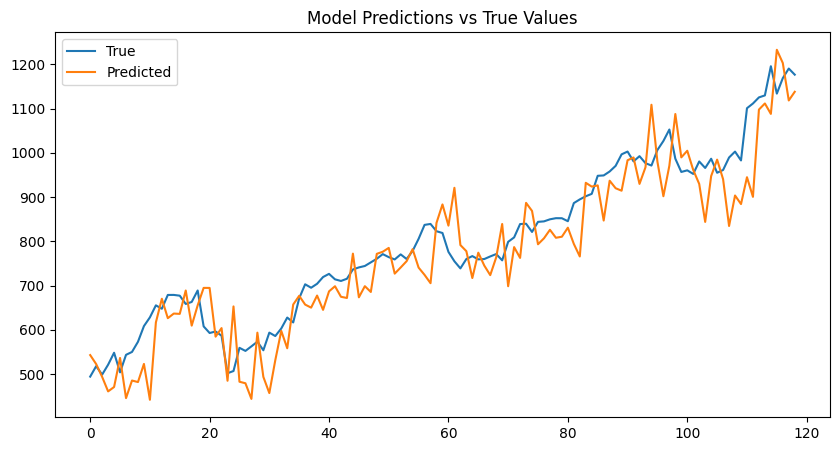

In [ ]:
# Predict on the test data and plot

Make_Predictions(best_model,Val_Out=False)


In [ ]:
# Compute the performance of the model on the testing data set
# Get predictions from the model
y_pred = Make_Predictions(best_model, X=X_test, plot=False, Val_Out=True)

# Compute Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print()

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Mean Squared Error: 0.019374742969122415
R-squared: 0.841704187021123


The tuned model shows slightly lower performance, with a marginally higher MSE and slightly lower R-squared compared to the simple RNN.

### **2.2 Advanced RNN Models**

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1**
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def Create_LSTM(config=None):

    if config == None:
        config = {'layers': 2, 'units':[125, 150], 'activation':['linear', 'linear'], 'dropout':[0, 0]}

    n = config['layers']

    model=Sequential()
    model.add(Input(shape = X_train.shape[1:]))

    for i in range(n):
        rtn_seq = (i<n-1)
        model.add(LSTM(units=config['units'][i], activation=config['activation'][i], dropout=config['dropout'][i], return_sequences=rtn_seq))

    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(model.summary())

    return model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 125)        │        74,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       165,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,751 (936.53 KB)

 Trainable params: 239,751 (936.53 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - loss: 0.0467 - mae: 0.1579 - val_loss: 0.1148 - val_mae: 0.3128
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0044 - mae: 0.0476 - val_loss: 0.1031 - val_mae: 0.2978
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mae: 0.0362 - val_loss: 0.0401 - val_mae: 0.1842
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - mae: 0.0323 - val_loss: 0.0284 - val_mae: 0.1560
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mae: 0.0286 - val_loss: 0.0096 - val_mae: 0.0862
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - mae: 0.0245 - val_loss: 0.0216 - val_mae: 0.0954
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1667e-04 - mae: 0.0174 - val_loss: 0.0951 - val_mae: 0.2273
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6255e-04 - mae: 0.0164 - val_loss: 0.2019 - val_mae: 0.3426
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

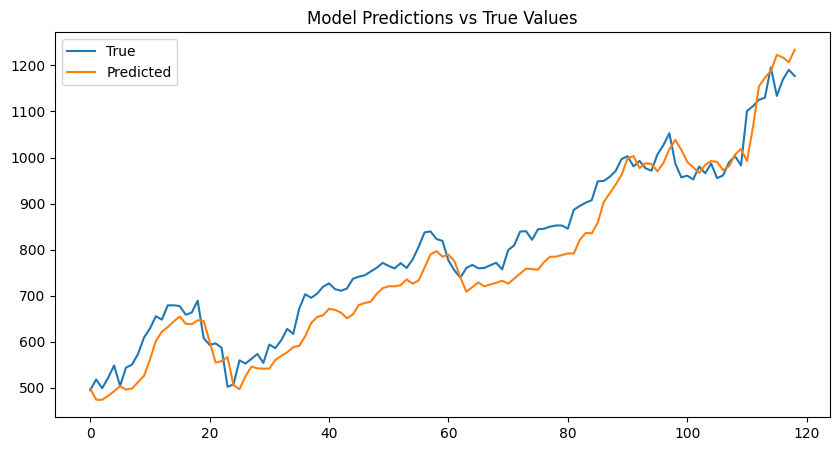

In [ ]:
model = Create_LSTM() # Create an instance of the RNN model using the Create_RNN function

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True) # Implement early stopping to prevent overfitting

# Train the Simple RNN model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Make_Predictions(model,Val_Out=False)

In [ ]:
# Compute the performance of the model on the testing data set

# Get predictions from the model
y_pred = Make_Predictions(model, X=X_test, plot=False, Val_Out=True)

# Compute Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Mean Squared Error: 0.00963432070373712
R-squared: 0.9212855297885599


In [ ]:
# # Define a function to create a model and specify default values for hyperparameters

def build_LSTM(hp):

    n = hp.Int('layers', min_value=1, max_value=4)

    model = Sequential()
    model.add(Input(shape = X_train.shape[1:]))

    for i in range(n):
        rtn_seq = (i<n-1)
        model.add(LSTM(units=hp.Int('units', min_value=75, max_value=150, step=25),
                        activation=hp.Choice('activation', values=['linear']),
                        dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
                        return_sequences=rtn_seq))

    model.add(Dense(units=1))

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    print(model.summary())

    return model

#### **2.2.2**
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration

hyperband_tunner = kt.Hyperband(
    build_LSTM,
    objective='val_mae',
    max_epochs=15,
    factor=3,
    directory='tempfile.mkdtemp',
    project_name='hyperband_rnn',
    overwrite=True
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 75)             │        29,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,476 (115.14 KB)

 Trainable params: 29,476 (115.14 KB)

 Non-trainable params: 0 (0.00 B)

None


#### **2.2.3**
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

hyperband_tunner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

hyperband_tunner.results_summary() # printing few good models


Trial 30 Complete [00h 00m 21s]
val_mae: 0.4343149662017822

Best val_mae So Far: 0.0575643815100193
Total elapsed time: 00h 07m 01s
Results summary
Results in tempfile.mkdtemp/hyperband_rnn
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0025 summary
Hyperparameters:
layers: 1
units: 100
activation: linear
dropout: 0.0
learning_rate: 0.001027905840968144
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.0575643815100193

Trial 0016 summary
Hyperparameters:
layers: 4
units: 125
activation: linear
dropout: 0.1
learning_rate: 0.0006681248953196665
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.10113290697336197

Trial 0019 summary
Hyperparameters:
layers: 1
units: 100
activation: linear
dropout: 0.1
learning_rate: 0.0005040515782337704
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.12073887139558792

Trial 0013 summary
Hyperp

In [ ]:
# printing the best parameters

best_hyperparameters = hyperband_tunner.get_best_hyperparameters(num_trials=1)[0] # Retrieve Best Hyperparameters:

best_hyperparameters.values # Now you can access the 'values' attribute


{'layers': 1,
 'units': 100,
 'activation': 'linear',
 'dropout': 0.0,
 'learning_rate': 0.001027905840968144,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

In [ ]:

# Build the best model using the best hyperparameters
best_model = hyperband_tunner.hypermodel.build(best_hyperparameters)

# Train the best model
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        49,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,301 (192.58 KB)

 Trainable params: 49,301 (192.58 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0202 - mae: 0.1072 - val_loss: 0.2109 - val_mae: 0.4343
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0581 - val_loss: 0.2214 - val_mae: 0.4502
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0478 - val_loss: 0.1156 - val_mae: 0.3263
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0459 - val_loss: 0.0940 - val_mae: 0.2953
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mae: 0.0351 - val_loss: 0.0417 - val_mae: 0.1956
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0101 - val_mae: 0.0883
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8708e-04 - mae: 0.0216 - val_loss: 0.0124 - val_mae: 0.0757
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2974e-04 - mae: 0.0197 - val_loss: 0.0441 - val_mae: 0.1484
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

In [ ]:
# Compute the performance of the model on the testing data set

# Get predictions from the model
y_pred = Make_Predictions(best_model, X=X_test, plot=False, Val_Out=True)

# Compute Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Mean Squared Error: 0.13874037802590625
R-squared: -0.1335386986866609


Plotting the actual vs predicted values

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


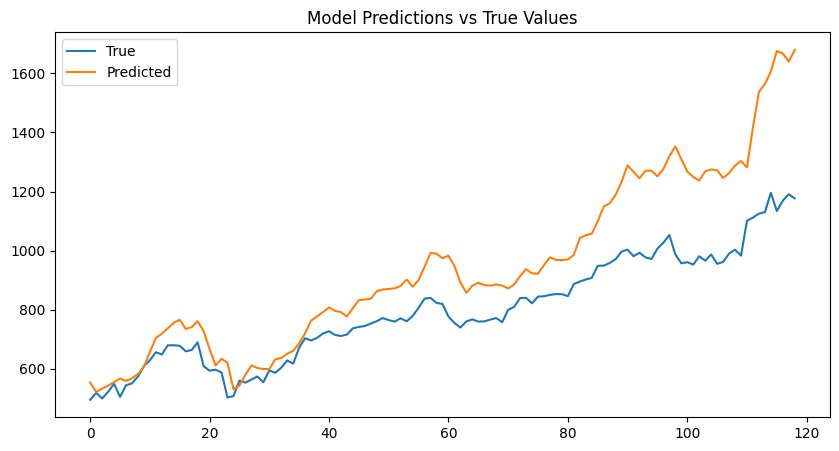

In [ ]:
# Predict on the test data

Make_Predictions(best_model, Val_Out=False)

## **4 Conclusion**

### **4.1 Conclusion and insights**

#### **4.1.1**
Conclude with the insights drawn and final outcomes and results.


Prediction of Amazon's stock Close Price using Recurrent Neural Networks (RNNs) and Long Short-Term Memory networks (LSTMs). The performance of each model was evaluated using Mean Squared Error (MSE) and R-squared (R²) metrics:

## Model Performance Comparison

| Model                  | Mean Squared Error (MSE) | R² Score |
|------------------------|--------------------------|----------|
| Simple RNN             | 0.0085                   | 0.9305   |
| RNN with Hyperband     | 0.0194                   | 0.8417   |
| Simple LSTM            | 0.0096                   | 0.9213   |
| LSTM with Hyperband    | 0.1387                   | -0.1335  |

---

### Model Performance Analysis

This table summarizes the performance of different recurrent neural network architectures, evaluated using **Mean Squared Error (MSE)** and the **R² Score**. These metrics help assess how well each model fits the data and predicts future values.

---

#### Simple RNN
- **MSE**: 0.0085  
- **R² Score**: 0.9305  

- The Simple RNN shows strong performance, with a low error and a high R² value indicating that over 93% of the variance in the target variable is explained by the model. This makes it a solid baseline.

---

#### RNN with Hyperband
- **MSE**: 0.0194  
- **R² Score**: 0.8417  

- Although hyperparameter tuning with Hyperband was expected to enhance performance, the tuned RNN underperforms compared to the untuned version. This could indicate suboptimal tuning results or overfitting due to the tuning process.

---

### Simple LSTM
- **MSE**: 0.0096  
- **R² Score**: 0.9213  

- The Simple LSTM performs similarly to the Simple RNN, slightly trailing in both metrics. It still provides a robust model with strong predictive accuracy and is well-suited for capturing temporal dependencies.

---

### LSTM with Hyperband
- **MSE**: 0.1387  
- **R² Score**: -0.1335  

- Surprisingly, the tuned LSTM performs poorly, with both a high MSE and a negative R² score—indicating that it performs worse than a horizontal mean-line predictor. This suggests serious overfitting or a misconfiguration in the hyperparameter search space.

- Hyperband discarded good models prematurely and too little time was given to promising candidates early on.
